In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

import time
import copy

import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt     
import itertools

import warnings
warnings.filterwarnings(action='ignore') 

c:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_Sampling_and_XAI으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_Sampling_and_XAI

In [ ]:
!pip install shap

In [2]:
'''
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
train = pd.read_csv('./data/time_series_data/cls_train.csv')
test = pd.read_csv('./data/time_series_data/cls_test.csv')

In [4]:
train['Activity'].value_counts() # 데이터 클래스 정보 확인

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [5]:
x_train = train.drop(['subject', 'Activity'], axis=1)
x_test = test.drop(['subject', 'Activity'], axis=1)
y_train = train['Activity']
y_test = test['Activity']

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (7352, 561)
y_train shape is (7352,)
-----------------------------------
x_test shape is (2947, 561)
y_test shape is (2947,)


In [6]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(pd.Series(y_train).value_counts())

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
dtype: int64


In [7]:
def windowing_process(x, y, window_size, shift_size, last = True):
    x = x.reset_index(drop=True)
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1]) # 마지막 index의 class를 사용하는 경우
        
        else:
            count_class = Counter(y[start_idx:start_idx + window_size])
            y_window.append(count_class.most_common(n=1)[0][0]) # 가장 많이 빈출한 class를 사용하는 경우
        
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [8]:
x_train, y_train = windowing_process(x_train, y_train, 10, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 10, 1, True)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (7343, 10, 561)
y_train shape is (7343,)
-----------------------------------
x_test shape is (2938, 10, 561)
y_test shape is (2938,)


In [9]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}') # (batch_size x seq_len x input_size)
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (5874, 10, 561)
y_train shape is (5874,)
-----------------------------------
x_train shape is (1469, 10, 561)
y_train shape is (1469,)
-----------------------------------
x_test shape is (2938, 10, 561)
y_test shape is (2938,)


In [10]:
# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # recurrent layer 설정
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, self.num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # RNN으로부터 output 도출
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)       
        out = self.fc(out[:, -1, :])
        return out

In [11]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, num_classes, device='cuda'):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.input_size = input_size
        self.num_classes = num_classes

    def train(self, model, dataloaders, criterion, num_epochs, optimizer, device):
        since = time.time() 

        train_loss_history = []        
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_acc = 0.0 # ACC는 클수록 좋은 metric이므로, 초기 낮은 값에서 갱신

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_corrects = 0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device, dtype=torch.long)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                        _, preds = torch.max(outputs, 1) # 첫 _에는 원래 실제 max값이 들어감 

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    running_total += labels.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                epoch_acc = running_corrects.double() / running_total

                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)


        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader, device):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():
            corrects = 0
            total = 0
            preds = []
            probs = []
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)

                # forward
                # input을 model에 넣어 output을 도출
                outputs = model(inputs)
                prob = outputs
                prob = nn.Softmax(dim=1)(prob)
                
                # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                _, pred = torch.max(outputs, 1)
                
                # batch별 정답 개수를 축적함
                corrects += torch.sum(pred == labels.data)
                total += labels.size(0)

                preds.extend(pred.detach().cpu().numpy())
                probs.extend(prob.detach().cpu().numpy())

            preds = np.array(preds)
            probs = np.array(probs)
            acc = (corrects.double() / total).item()
       
        return preds, probs, acc

In [12]:
batch_size = 128
input_size = x_train.shape[2]
num_classes = len(np.unique(y_train))
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 

In [13]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [14]:
model =  RNN_model(input_size, hidden_size, num_layers, num_classes, bidirectional, device)
model = model.to(device)

In [15]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, num_classes, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer, device)


Epoch 1/100
train Loss: 1.5277 Acc: 0.4314
val Loss: 1.2522 Acc: 0.5956

Epoch 10/100
train Loss: 0.1858 Acc: 0.9549
val Loss: 0.1856 Acc: 0.9530

Epoch 20/100
train Loss: 0.0467 Acc: 0.9927
val Loss: 0.0761 Acc: 0.9714

Epoch 30/100
train Loss: 0.0220 Acc: 0.9963
val Loss: 0.0491 Acc: 0.9843

Epoch 40/100
train Loss: 0.0115 Acc: 0.9985
val Loss: 0.0379 Acc: 0.9877

Epoch 50/100
train Loss: 0.0067 Acc: 0.9997
val Loss: 0.0484 Acc: 0.9864

Epoch 60/100
train Loss: 0.0044 Acc: 0.9997
val Loss: 0.0321 Acc: 0.9884

Epoch 70/100
train Loss: 0.0063 Acc: 0.9997
val Loss: 0.0800 Acc: 0.9775

Epoch 80/100
train Loss: 0.0125 Acc: 0.9964
val Loss: 0.0497 Acc: 0.9830

Epoch 90/100
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0461 Acc: 0.9864

Epoch 100/100
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0436 Acc: 0.9877

Training complete in 0m 19s
Best val Acc: 0.992512


## SHAP For Time-Series Data

Lime for Time-Series data using sklearn : https://github.com/emanuel-metzenthin/Lime-For-Time

In [89]:
import shap

In [91]:
explainer = shap.DeepExplainer(model=model,data=torch.FloatTensor(x_test[:200]).to(device))

In [92]:
model.train()

RNN_model(
  (rnn): RNN(561, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [94]:
shap_values = explainer.shap_values(torch.FloatTensor(x_test[255:256]).to(device))

In [96]:
print(len(shap_values), '/' , shap_values[0].shape)

6 / (1, 10, 561)


In [98]:
import seaborn as sns

Text(0.5, 1.0, 'RNN Shap Value Visualization')

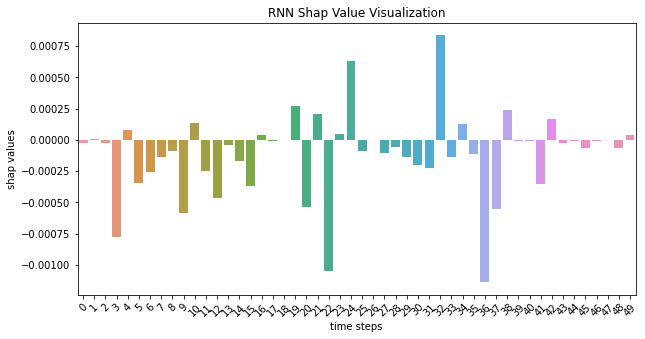

In [99]:
fig = plt.figure(figsize=(10,5))

#plt.figure(figsize=(10,6))
time_steps = np.array([str(i) for i in range(561)])
sns.barplot(x=time_steps[:50], y=shap_values[0][0][0][:50])

plt.ylabel('shap values')
plt.xlabel('time steps')
plt.xticks(rotation=45)
plt.title('RNN Shap Value Visualization')


Text(0.5, 1.0, 'RNN Absolute Shap Value Visualization')

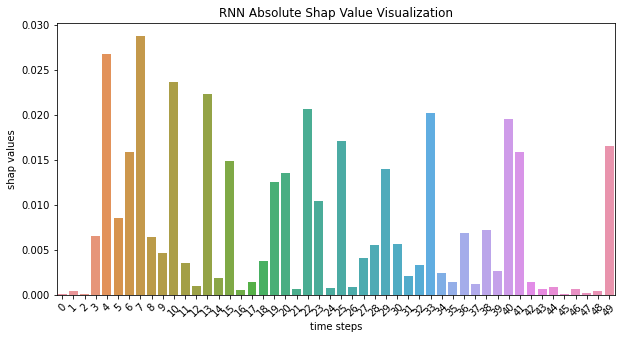

In [186]:
fig = plt.figure(figsize=(10,5))

#plt.figure(figsize=(10,6))
time_steps = np.array([str(i) for i in range(561)])
sns.barplot(x=time_steps[:50], y=np.abs(shap_values[0][0][0][:50]))

plt.ylabel('shap values')
plt.xlabel('time steps')
plt.xticks(rotation=45)
plt.title('RNN Absolute Shap Value Visualization')

## 1D-CNN & SHAP

In [172]:
# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

class CNN_model(nn.Module):
    def __init__(self, in_channels,  num_classes):
        super(CNN_model, self).__init__()
        
        # 1d-CNN block
        self.block1 = nn.Sequential(nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=7, stride=4, padding=3),
                               nn.BatchNorm1d(32),
                               nn.ReLU(True))
        
        self.block2 = nn.Sequential(nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=4, padding=3),
                               nn.BatchNorm1d(64),
                               nn.ReLU(True))

        self.block3 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=3, padding=2),
                               nn.BatchNorm1d(128),
                               nn.ReLU(True))
        
        self.block4 = nn.Sequential(nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=3, padding=2),
                               nn.BatchNorm1d(256),
                               nn.ReLU(True))
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(nn.Linear(256,64),
                                 nn.ReLU(True),
                                 nn.Linear(64,num_classes))
        
    def forward(self, x):
        """x : B,10,561"""
        x = self.block1(x) # B, 32, 141
        x = self.block2(x) # B, 64, 36
        x = self.block3(x) # B, 128, 12
        x = self.block4(x) # B, 256, 4
        x = self.avg_pool(x) # B, 256, 1
        x = x.squeeze(dim=-1)
        out = self.fc(x) # B, num_classes
        return out

In [173]:
in_channels= x_train.shape[1]
num_classes = len(np.unique(y_train))
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 


In [174]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [175]:
model =  CNN_model(in_channels=in_channels, num_classes=num_classes)
model = model.to(device)

dataloaders_dict = {'train': train_loader, 'val': valid_loader}

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [176]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, num_classes, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer, device)


Epoch 1/30
train Loss: 1.4868 Acc: 0.4522
val Loss: 1.1910 Acc: 0.7583

Epoch 10/30
train Loss: 0.0432 Acc: 0.9957
val Loss: 0.1058 Acc: 0.9646

Epoch 20/30
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.0923 Acc: 0.9646

Epoch 30/30
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.0981 Acc: 0.9653

Training complete in 0m 9s
Best val Acc: 0.967325


In [177]:
model.eval()
explainer = shap.DeepExplainer(model=model,data=torch.FloatTensor(x_test[:200]).to(device))

In [178]:
shap_values = explainer.shap_values(torch.FloatTensor(x_test[255:256]).to(device))

Text(0.5, 1.0, '1DCNN Shap Value Visualization')

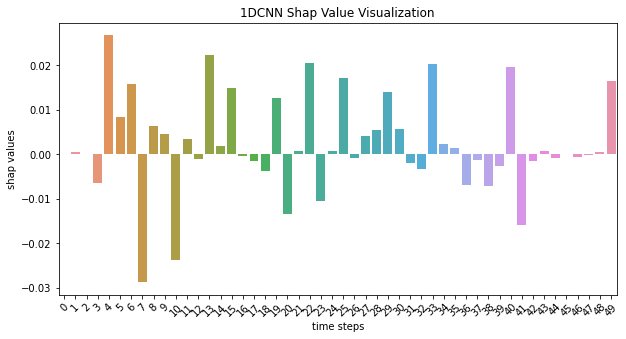

In [188]:
fig = plt.figure(figsize=(10,5))

#plt.figure(figsize=(10,6))
time_steps = np.array([str(i) for i in range(561)])
sns.barplot(x=time_steps[:50], y=shap_values[0][0][0][:50])

plt.ylabel('shap values')
plt.xlabel('time steps')
plt.xticks(rotation=45)
plt.title('1DCNN Shap Value Visualization')